In [210]:
import keras
import data_loading
import tensorflow as tf
import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt

In [211]:
image_size = 240
# channels = 4
channels = 1

In [212]:
def conv_relu_block(input_tensor, num_of_filters):

    conv_relu = keras.layers.Conv2D(activation='relu',
                                    filters=num_of_filters,
                                    kernel_size=(3, 3),
                                    strides=1,
                                    padding='same',
                                    data_format='channels_first')(input_tensor)
    conv_relu = keras.layers.Conv2D(activation='relu',
                                    filters=num_of_filters,
                                    kernel_size=(3, 3),
                                    strides=1,
                                    padding='same',
                                    data_format='channels_first')(conv_relu)

    return conv_relu



In [213]:
def max_pool(input_tensor):
    return keras.layers.MaxPooling2D(pool_size=(2, 2),
                                     strides=None,
                                     padding='same',
                                     data_format='channels_first')(input_tensor)



In [214]:
def up_sample(input_tensor, encode_input_tensor):
    us = keras.layers.UpSampling2D(size=(2, 2),
                                   data_format='channels_first')(input_tensor)
    concat = keras.layers.Concatenate(axis=1)(inputs=[us, encode_input_tensor])
    return concat



In [215]:
def UNet():

    filters = [1, 64, 128, 256, 512, 1024]

    input_data = keras.layers.Input(shape=(channels, image_size, image_size))
    
    print(input_data.shape)

    # encode
    cr1 = conv_relu_block(input_data, filters[1])
    md1 = max_pool(cr1)
    cr2 = conv_relu_block(md1, filters[2])
    md2 = max_pool(cr2)
    cr3 = conv_relu_block(md2, filters[3])
    md3 = max_pool(cr3)
    cr4 = conv_relu_block(md3, filters[4])
    md4 = max_pool(cr4)

    # bottom
    cr5 = conv_relu_block(md4, filters[5])

    # decode
    us1 = up_sample(cr5, cr4)
    cr6 = conv_relu_block(us1, filters[4])
    us2 = up_sample(cr6, cr3)
    cr7 = conv_relu_block(us2, filters[3])
    us3 = up_sample(cr7, cr2)
    cr8 = conv_relu_block(us3, filters[2])
    us4 = up_sample(cr8, cr1)
    cr9 = conv_relu_block(us4, filters[1])

    output_data = keras.layers.Conv2D(filters=filters[0],
                                      kernel_size=(1, 1),
                                      padding="same",
                                      activation="sigmoid",
                                      data_format='channels_first')(cr9)

    model = keras.models.Model(input_data,
                               output_data,
                               name="UNet")

    return model

In [216]:
model = UNet()
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])



(None, 1, 240, 240)


## Sequence data generator

In [230]:
class SequenceDataGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, file_path='../dataset/', mode='training', glioma_type='HGG'):
        self.dir_paths = []
        for directory in os.listdir(file_path + mode + "/" + glioma_type):
            self.dir_paths.append(os.path.join(file_path, mode, glioma_type, directory))
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.dir_paths) / float(self.batch_size)))
    
    def __get_image_array__(self, file_path):
            return sitka.GetArrayFromImage(sitka.ReadImage(file_path, sitka.sitkFloat32))
    
    def __get_mask_and_slice_position__(self, dir_path):

        mask_file_name = dir_path[dir_path.rfind('\\') + 1:] + "_seg.nii.gz"
        img = self.__get_image_array__(os.path.join(dir_path, mask_file_name))
        slice_position = random.randint(20, 120)
        while True:
            mask = img[slice_position, :, :]
            if mask.max() > 0:
                return mask, slice_position
            else:
                slice_position = (slice_position + 1) % 150
    
    def __load__(self, dir_path):

        ### 
        tensor = np.zeros((240, 240))        
        mask, slice_position = self.__get_mask_and_slice_position__(dir_path)
        
        for file in os.listdir(dir_path):
            img = self.__get_image_array__(os.path.join(dir_path, file))
            if file.find('seg') == -1:
                tensor = np.dstack((tensor, img[slice_position, :, :]))

        return tensor.swapaxes(0, 2)[1:, :, :], mask.swapaxes(0, 1)

    def __getitem__(self, idx):
        batch_x = self.dir_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        masks = []
        
        for dir_path in batch_x:
            image_, mask_ = self.__load__(dir_path)
            images.append([image_[3]])
            masks.append([mask_])
        
        return np.array(images), np.array(masks)

In [227]:
gen = SequenceDataGenerator(batch_size=1, mode="training")
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

Getting item
(1, 1, 240, 240) (1, 1, 240, 240)


TypeError: Invalid shape (1, 240, 240) for image data

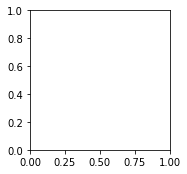

In [228]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[0][0])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y, (image_size, image_size)), cmap="gray")

In [231]:
batch_size = 2
epochs = 2

train_gen = SequenceDataGenerator(batch_size=1, mode="training")
valid_gen = SequenceDataGenerator(batch_size=1, mode="validation")

train_steps = 239//batch_size
valid_steps = 20//batch_size

print(train_steps)

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

119
Epoch 1/2
  7/119 [>.............................] - ETA: 16:17 - loss: 2.7105 - accuracy: 0.8587

KeyboardInterrupt: 